# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Submission

With this project, I submit the following files and folders:

1. `README.md`: this readme file, generated from main.ipynb
2. `main.ipynb`: jupyter notebook containing the documentation and the main part of the pipeline
3. `lib.py`: library with functions mainly from the lecture
4. `lib2.py`: library with additions functions 
5. `project_video_out.mp4`: processed video



## Warmup
---
Before I start considering the rubric points, I add some of the exercises from the course.

### Exploring Colorspaces

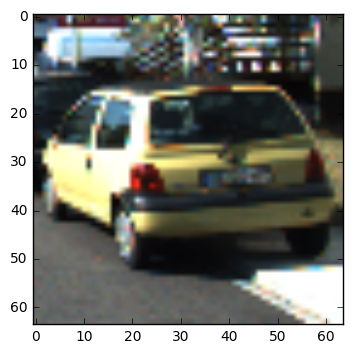

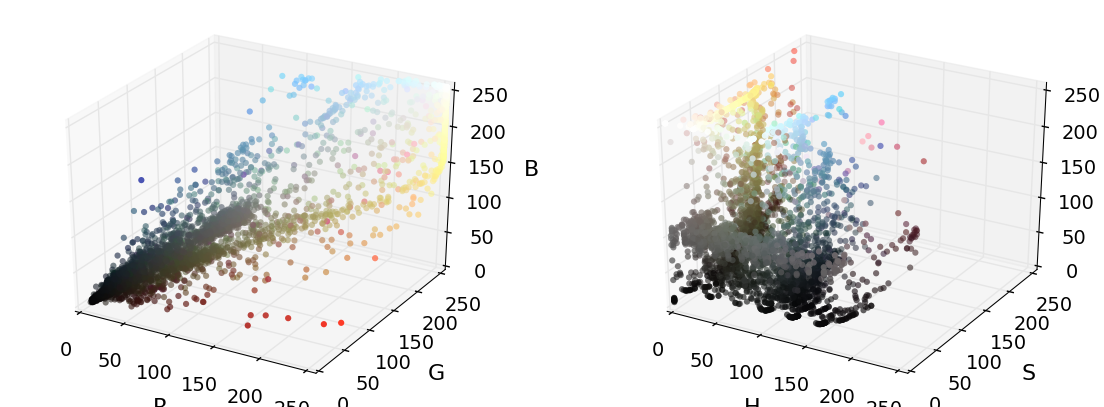

In [1]:
# this code is mainly from the lecture.

from helpers import *
#from lecture.plot3d import plot3d
from lib import plot3d
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

# Read a color image
img = cv2.imread("./lecture/14_color_spaces/25.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plt.figure(figsize=(14,4))
plt.imshow(bgr_rgb(img))

fig=plt.figure(figsize=(14,5))

ax=fig.add_subplot(1, 2, 1, projection='3d')
plot3d(ax, img_small_RGB, img_small_rgb)

ax=fig.add_subplot(1, 2, 2, projection='3d')
plot3d(ax, img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()


In HSV space, the yellow dots (the car) are (more or less) in a plane. Common to most cars: red lights in the back, black wheels. Black is not a color, so H channel does not help here...

### Combine and Normalize Features
Playing with spatial and histogram features. Note: for these initial steps, I reduce the to `nreduction` samples in the cars and in the not-cars data set.

number of samples in cars data set:  8792
number of samples in not-cars data set:  8968
reduction of samples in cars and not-cars data set to:  500
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168


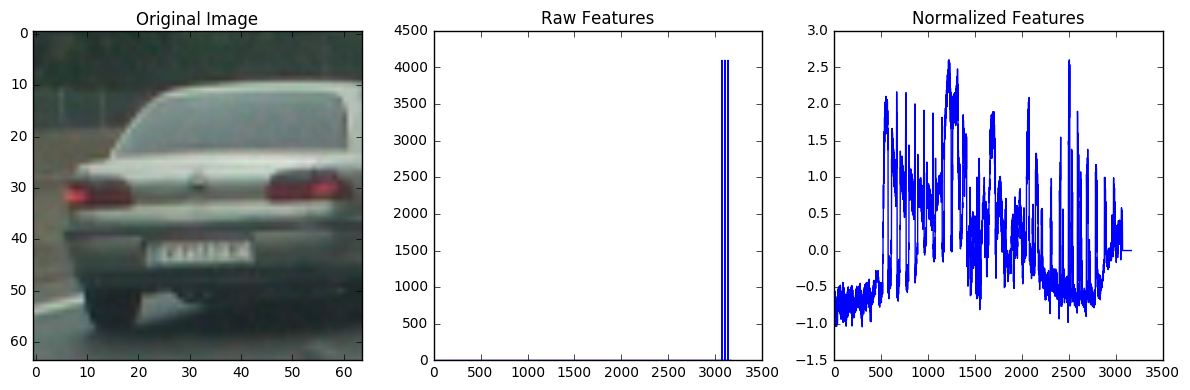

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from lib import *

cars=[]
for d in glob.glob('data/vehicles/G*'):
    cars.extend(glob.glob(d+'/*.png'))
for d in glob.glob('data/vehicles/K*'):
    cars.extend(glob.glob(d+'/*.png'))

print("number of samples in cars data set: ", len(cars))
    
notcars = []
for d in glob.glob('data/non-vehicles/Extras/*.png'):
    notcars.append(d)
for d in glob.glob('data/non-vehicles/GTI/*.png'):
    notcars.append(d)
    
print("number of samples in not-cars data set: ", len(notcars))

#nreduction=8792
nreduction=500
cars_red=cars[0:nreduction] # reduce number of samples for testing
notcars_red=notcars[0:nreduction] # reduce number of samples for testing
print("reduction of samples in cars and not-cars data set to: ", nreduction)

spatial=32
histbin=32
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')

car_features = extract_features(cars_red, color_space='RGB', spatial_size=(spatial, spatial),
                               hist_bins=histbin, hog_feat=False)
notcar_features = extract_features(notcars_red, color_space='RGB', spatial_size=(spatial, spatial),
                               hist_bins=histbin, hog_feat=False)

print('Feature vector length:', len(notcar_features[0]))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars_red))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars_red[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### Train a Classifier
Define a labels vector $y$ for cars (1) and non-car objects (0):

In [3]:
import numpy as np
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

Now stack the features vectors together and apply a normalization:

In [4]:
from sklearn.preprocessing import StandardScaler
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

Split feature vectors and labels into training and test set using `train_test_split` from `sklearn`. Hint: the package name depends on the version on `sklearn`, see comment.

In [5]:
# sklearn <0.18:
#from sklearn.cross_validation import train_test_split
# scikit-learn >= 0.18:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

Now let's train a classifier:

In [6]:
from sklearn.svm import LinearSVC
import time
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


1.38 Seconds to train SVC...


Accuracy & Predictions:

In [7]:
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.92
My SVC predicts:  [ 0.  0.  0.  0.  0.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  1.]
0.00121 Seconds to predict 10 labels with SVC


## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
---
Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

## Writeup / README
---

- Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!


## Histogram of Oriented Gradients (HOG)
---

Before I start with implementing the final classifier, I want to play with the hog features and again train a classifier on a reduced data set.

In [8]:

### TODO: Tweak these parameters and see how the results change.
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


t=time.time()

car_features = extract_features(cars_red, color_space='HLS', 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=False, 
                        hist_feat=False, hog_feat=True)
notcar_features = extract_features(notcars_red, color_space='HLS', 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=False, 
                        hist_feat=False, hog_feat=True)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

3.27 Seconds to extract HOG features...
Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 10584
0.23 Seconds to train SVC...
Test Accuracy of SVC =  0.995
My SVC predicts:  [ 0.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
0.00164 Seconds to predict 10 labels with SVC


### Feature Detection

- Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

The `vehicle` and `non-vehicle` images have been loaded in the __Combine and Normalize Features__ section.  

I then explored different color spaces and different HOG parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  

I tried various combinations of parameters and finally settled on the parameters as defined below. The accuracy of the SVC as described in the next section is fine with this set of parameters (>98%).


In [9]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

#color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#spatial_size = (32, 32) # Spatial binning dimensions
#hist_bins = 32    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off

#color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 18  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#spatial_size = (24, 24) # Spatial binning dimensions
#hist_bins = 16    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off

nreduction=8792
#nreduction=1000
cars_red=cars[0:nreduction] # reduce number of samples for testing
notcars_red=notcars[0:nreduction] # reduce number of samples for testing
print("reduction of samples in cars and not-cars data set to: ", nreduction)

car_features = extract_features(cars_red, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars_red, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("Done.")

reduction of samples in cars and not-cars data set to:  8792
Done.



### Training the Classifier

- Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using features vector and labels vector as defined before. Since videos are sequences of images where the target object (vehicles in this case) appear almost identical in a whole series of images, even a randomized train-test split will be subject to overfitting because images in the training set may be nearly identical to images in the test set. Therefore I split into test and training set _before_ shuffling. The accuracy of the classifier then can be checked on the test set.


In [10]:
from lib2 import split_n_shuffle

In [11]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVC
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = split_n_shuffle(scaled_X, y, 0.8)

## Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
#X_train, X_test, y_train, y_test = train_test_split(
#    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
#param_grid = [
#  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
# ]
#svc = GridSearchCV(SVC(), param_grid)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

#svc.fit(scaled_X, y)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6060
12.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9861


Training the SVC with 8792 cars and not-cars images takes about 2.5s on my machine. Total time ~2minutes.

#### Decision Surface

Let's have a look at the distance to the decision surface:

In [12]:
d=svc.decision_function(X_test)

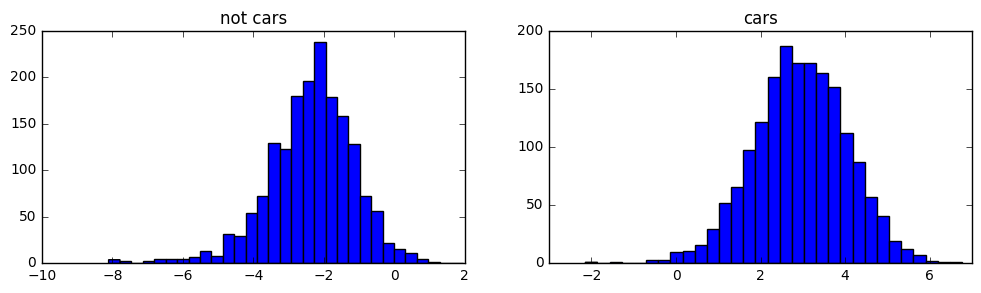

In [13]:
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
_ = plt.hist(d[y_test==0], bins=31) 
plt.title("not cars")
plt.subplot(122)
_ = plt.hist(d[y_test==1], bins=31) 
plt.title("cars")

__Conclusion:__ It might be useful not only to use the output of the predict function of the SVC, but instead look at the distance to the decision surface. Let's define a class of its own for this purpose (see class `Classifier` in `lib2.py`):


In [14]:
from lib2 import Classifier

clf=Classifier(svc, minDist=-0.5)
clf.score(X_test, y_test)

0.97413303013075614

Now read in an image and search for cars...

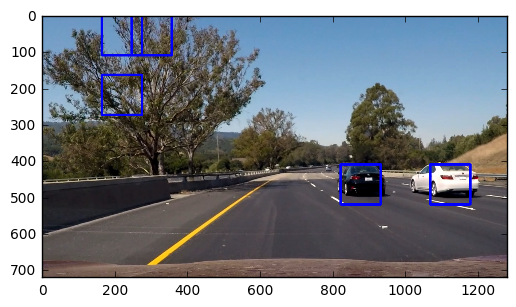

In [15]:
y_start_stop = [None, None] # Min and max in y to search in slide_window()

image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(110, 110), xy_overlap=(0.25, 0.25))

hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)



Obviously, it helps very much to increase the number of images for training the SVC. Also, the window size for searching seems to be crucial and must be adapted to the distance of camera->car.

I played with different color spaces, and first, HLS turned out to be best. I assume this is due to the separation into color, brightness and saturation, where saturation gives good gradients and color helps identifying the color of cars. After more experiments with the test images, I settled with YCrCb, which gave the overall best results wrt. correct detections and false detections.

Best comprimise between reliability and computational effort so far (this choice was adapted after the first review; suggestion by the reviewer was to reduce spacial binning dimensions and to refmove histogram features completely):

    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    spatial_feat = True # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off



## Sliding Window Search
---

### Implementation

- Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

First, some experiments:

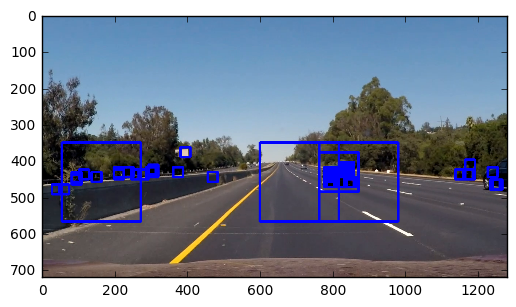

In [16]:

#image = mpimg.imread('test_images/test6.jpg')
#draw_img = np.copy(image)
#img = image.astype(np.float32)/255

images=[mpimg.imread('project_video_frames/004.png'), 
        mpimg.imread('project_video_frames/016.png'), 
        mpimg.imread('project_video_frames/028.png'), 
        mpimg.imread('project_video_frames/031.png'), 
        mpimg.imread('project_video_frames/041.png'), 
        mpimg.imread('project_video_frames/052.png')]

I=[5]

#image = mpimg.imread('project_video_frames/052.png')
image=images[I[0]]
draw_img = np.uint8(np.copy(image)*255)
out_img=np.copy(draw_img)
img = image

boxes=[]

ystart = 350
scale = 1.7
ystop = ystart+2*int(scale*64)+1
out_img, b = find_cars(img, out_img, ystart, ystop, scale, clf, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 0) #, hist_bins)
boxes.extend(b)
scale = 1.7*0.25
out_img, b = find_cars(img, out_img, ystart, ystop, scale, clf, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 0)
boxes.extend(b)
#ystart = ystart-25
scale = 1.7*2
ystop = ystart+2*int(scale*64)+1
out_img, b = find_cars(img, out_img, ystart, ystop, scale, clf, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 0)
boxes.extend(b)
#ystart = ystart-25
scale = 1.7*3
ystop = ystart+2*int(scale*64)+1
out_img, b = find_cars(img, out_img, ystart, ystop, scale, clf, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 0)
boxes.extend(b)

plt.imshow(out_img)

This seems to be a good starting point to think about how to systematically search the image for cars without the need to search all the (lower half of) the image. For shure, cars that are closer to the camera will appear bigger than cars that are farther. Also, it is very unlikely that cars suddenly appear in the center of the image. Either they appear at the horizon, or they appear from the lower part of the image. Since we know that we are driving on the left line, we even only need to look for cars appearing on the lower right side of the image.

Two steps:
1. initialize: search the whole (lower part of the) image
2. processing frames: only search where a car has been found before, on the horizon, and on the lower right part of the image.

Further improvement: If we knew the position of the lane lines and the curvature of the street, we could search for cars even more systematically (P4, lane line finding). This will not be imlemented here (running out of time). However, I will restrict the search window __manually__ to a region that contains the street plus some height offset considering the height of cars. In a real-world application, this knowledge must be fed into the pipeline from an additional computation.

#### Refining the pipeline: defining the global search window

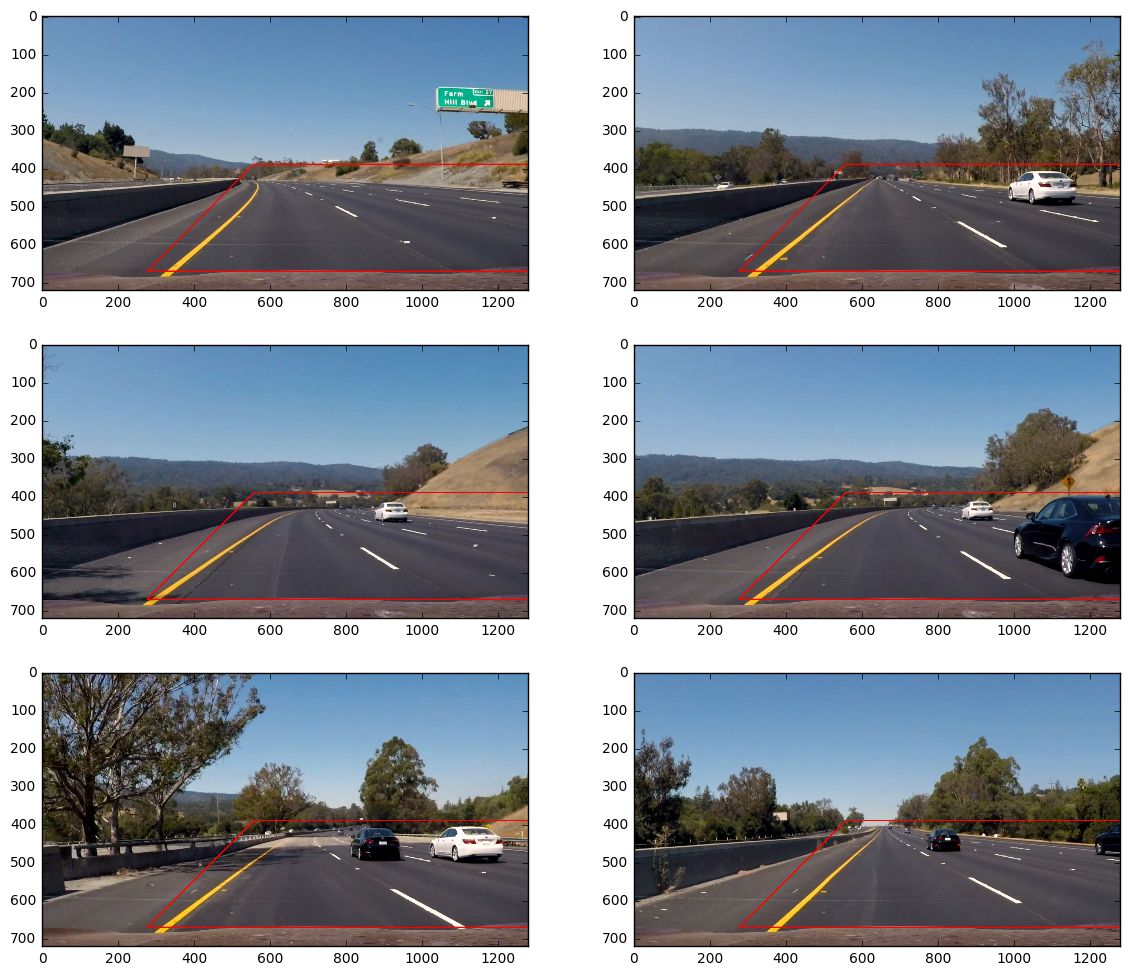

In [17]:
plt.figure(figsize=(14,12))
s=images[0].shape

h=s[0]; w=s[1]

globalWindow=[[556, 390], [w, 390], [w, h-50], [276, h-50]]
    
for i in range(6):
    plt.subplot(3, 2, i+1)
    rgb_poly=np.uint8(np.copy(images[i])*255)
    cv2.polylines(rgb_poly, np.array([globalWindow]), 1, (255,0,0), 2)
    plt.imshow(rgb_poly)


#### Cutting out the region of interest

Now, the polygon that was defined as `globalWindow` will be used to take a rectangular sub image that will be used for image processing. See `lib2.py`, `region_of_interest()`.

(280, 1004, 3)


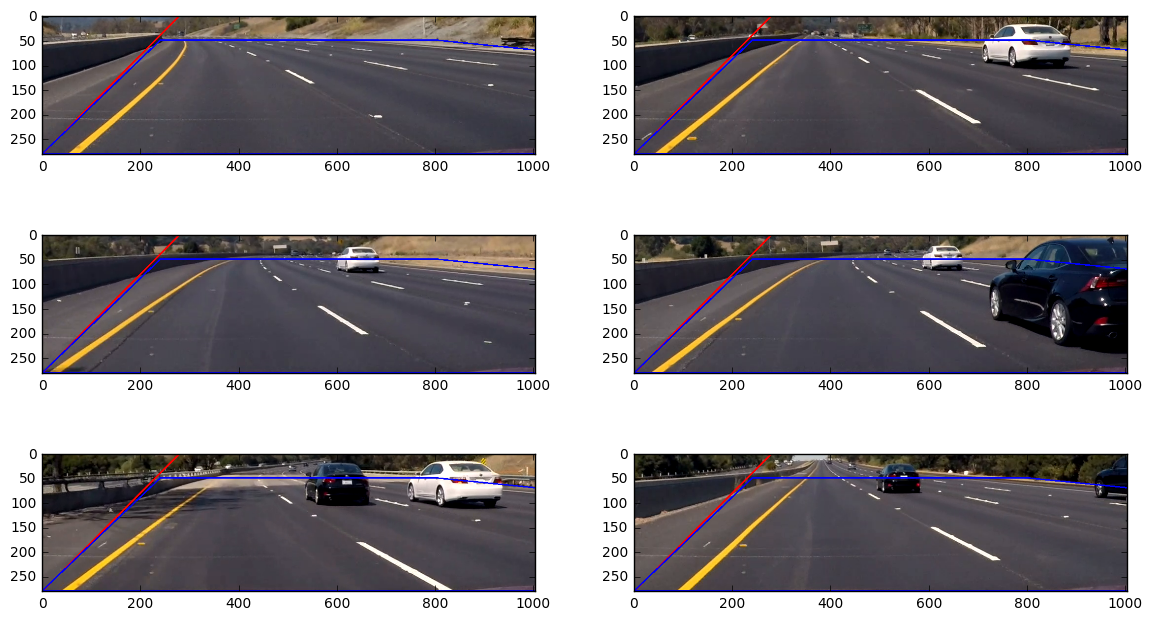

In [18]:
from lib2 import region_of_interest

plt.figure(figsize=(14,8))

s=region_of_interest(images[0], globalWindow).shape
print(s)
groundWindow=[[0,s[0]-1],[240,50],[800,50],[s[1]-1,70], [s[1]-1,s[0]-1]]
    
for i in range(6):
    plt.subplot(3, 2, i+1)
    rgb_poly=np.uint8(np.copy(images[i])*255)
    cv2.polylines(rgb_poly, np.array([globalWindow]), 1, (255,0,0), 2)
    roi=region_of_interest(rgb_poly, globalWindow)
    cv2.polylines(roi, np.array([groundWindow]), 1, (0,0,255), 2)
    plt.imshow(roi)


#### Perspective Scale
For rescaling the search boxes, I take perspective into account. Therefore I draw a polygon on a straight part of the street, marking lane lines, and derive a length scaling factor from the points that I selected manually. See `lib2.py`, `perscpective_scale()`.

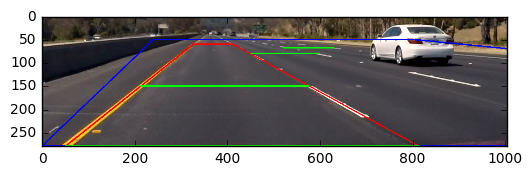

In [19]:
from lib2 import perspective_scale

roi=region_of_interest(np.uint8(np.copy(images[1])*255), globalWindow)
src=[[326, 60], [411, 60], [812, 280], [50, 280]]
roi=cv2.polylines(roi, np.array([src]), 1, (255,0,0), 2)

cv2.polylines(roi, np.array([groundWindow]), 1, (0,0,255), 2)

#perspective_scale(280)
l0=src[2][0]-src[3][0]
pt1=tuple(src[3]); pt2=(pt1[0]+l0, pt1[1])
cv2.line(roi, pt1, pt2, (0,255,0), thickness=4)
pt1=(213, 150); pt2=(pt1[0]+int(l0*perspective_scale(pt1[1])), pt1[1])
cv2.line(roi, pt1, pt2, (0,255,0), thickness=4)
pt1=(450, 80); pt2=(pt1[0]+int(l0*perspective_scale(pt1[1])), pt1[1])
cv2.line(roi, pt1, pt2, (0,255,0), thickness=2)
pt1=(520, 68); pt2=(pt1[0]+int(l0*perspective_scale(pt1[1])), pt1[1])
cv2.line(roi, pt1, pt2, (0,255,0), thickness=2)

plt.imshow(roi)


#### Define Baseline for Search Boxes
The baseline for all search boxes will be inside the polygon defined by `groundWindow`. For all `y` values inside that window, I need to compute a left and a right boundary. See `lib2.py`, `left_boundary()` and `right_boundary()`. Furthermore, I define top and bottom boundary `top_boundary()`, `bottom_boundary()`. 

All coordinates from now relative to the region of interest, including `groundWindow`.

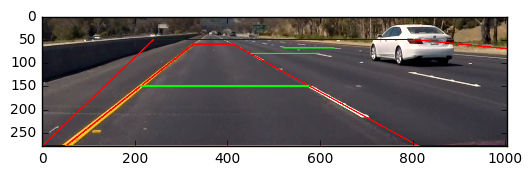

In [20]:
from lib2 import left_boundary, right_boundary, top_boundary, bottom_boundary

bb=bottom_boundary(); lbb=left_boundary(bb); rbb=(right_boundary(70))
tb=top_boundary(); ltb=left_boundary(tb); rtb=(right_boundary(tb))

cv2.line(roi, (lbb,bb), (ltb,tb), (255,0,0), thickness=2)
cv2.line(roi, (rbb,70), (rtb,tb), (255,0,0), thickness=2)
plt.imshow(roi)


#### Some Examples of Scaled Search Windows

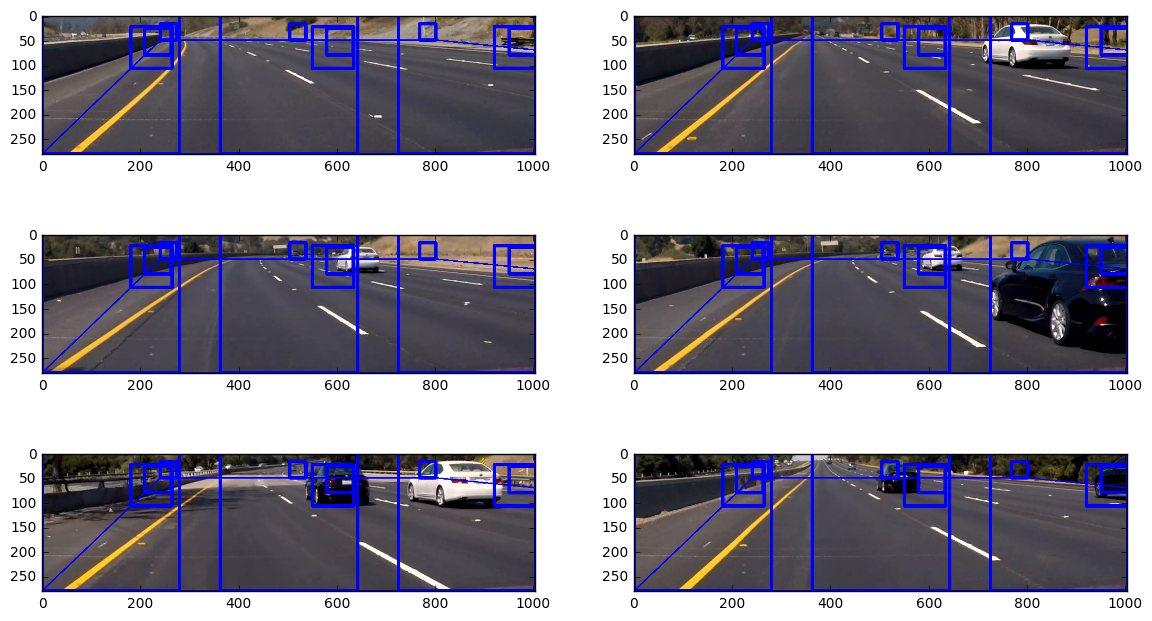

In [21]:
bl=int(0.37*l0)
ys=[tb,80, int(0.25*(bb-tb)+tb), bb]
ps=[0.0, 0.5, 1.0]

plt.figure(figsize=(14,8))

for i in range(6):
    roi=region_of_interest(np.uint8(np.copy(images[i])*255), globalWindow)
    cv2.polylines(roi, np.array([groundWindow]), 1, (0,0,255), 2)

    for y in ys:
        lb=left_boundary(y); rb=right_boundary(y)
        s=max(perspective_scale(y), 0.12)
        bl_s=int(bl*s)
        mDist=rb-lb-bl_s
        for p in ps:
            xl=lb+int(mDist*p); xr=xl+bl_s
            yb=y; yt=yb-bl_s
            cv2.rectangle(roi,(xl,yb),(xr,yt),(0,0,255),6) 
            #print((xl,yb),(xr,yt))

    plt.subplot(3, 2, i+1)
    plt.imshow(roi)



### Classifier Optimization

- Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

__review finding:__

Ultimately I searched on __five__ scales using YCrCb 3-channel HOG features plus spatially binned color in the feature vector, which provided a nice result. In order to remove false positives, I also used the `decision_function` method of `LinearSVC`. Compare also class `Classifier`, in `lib2.py`.


#### Refining the pipeline: find_cars2

First of all, I need a function to determine the position of cars, which means, finding the boxes. Basically, I take the function find_cars from the lecture, just removing the drawing functionality, and only returning the boxes. Based on that, I define the class `Scan`, with two important methods, `scan_global()` and `scan_local()`. The first one, `scan_global()`, scans the whole region of interest, taking different scales corresponding to perspective scaling as described before. It can be used to scan a single image, and it will be used during video processing for scanning _the first frame only_. For the following frames, I will only use `scan_local()`. It differs in that it does not scan the whole region of interest, but only 

1. the horizon, since cars can enter the region of interest from there
2. the right half of the region of interest, since we are on the left lane, so no cars entering the roi from there
3. a list of bounding boxes where cars have been detected in previous frames.

Direct in front of our own car, no other cars can appear suddenly (only from the horizon), so no need to scan here. Of course, in a real world application, one has to think about the validity of this approach. Here, it works fine.

In [22]:
from lib2 import find_cars2, rectangle

In [23]:
class Scan():
    def __init__(self, clf, X_scaler):
        self.clf=clf
        self.X_scaler=X_scaler
        self.color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.cells_per_step_x = 2
        self.cells_per_step_y = 2
        self.hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (16, 16) # Spatial binning dimensions
        self.hist_bins = 32    # Number of histogram bins
        self.spatial_feat = True # Spatial features on or off
        self.hist_feat = False # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        
        self.globalWindow=[[556, 390], [1280, 390], [1280, 720-50], [276, 720-50]]

        # perspective polygon
        src=[[326, 60], [411, 60], [812, 280], [50, 280]]
        l0=src[2][0]-src[3][0]
        self.bl=int(0.36*l0) # basic length
        self.scaleMin=bl/64 # scale factor for rescaling bl to 64 pixels

        # generate y values with approx. perspectively scaled spacing
        ys=range(50, bb, int((bb-50)/4))
        ss=[perspective_scale(y) for y in ys]
        ss=ss/np.sum(ss)
        sum_s=0
        y=50; ys=[y]
        for s in ss:
            y=y+s*(bb-50)
            ys.append(int(y))
        self.ys=ys
        
    # coordinate transformation of a list of points from roi to global coordinates
    def to_global(self, p_list):
        rect=rectangle(self.globalWindow)
        return [[p[0]+rect[0][0], p[1]+rect[0][1]] for p in p_list]
    
    # coordinate transformation of a list of points from global coordinates to roi
    def to_roi(self, p_list):
        rect=rectangle(self.globalWindow)
        return [[p[0]-rect[0][0], p[1]-rect[0][1]] for p in p_list]
    
    def fc(self, roi, lb, rb, ystart, ystop, s):
        return find_cars2(roi, lb, rb, ystart, ystop, s,
                          self.clf, self.X_scaler, self.orient, 
                          self.pix_per_cell, self.cell_per_block, 
                          self.cells_per_step_x, self.cells_per_step_y,
                          self.spatial_size, self.hist_bins)
        
    def scan_global(self, image):
        roi=region_of_interest(image, self.globalWindow)
        boxes=[]
        for y in self.ys:
            lb=left_boundary(y); rb=right_boundary(y)
            s=max(perspective_scale(y), 0.10)
            bl_s=int(self.bl*s)+1
            ystart = max(y-int(bl_s*1.5), 0)
            ystop = y+int(1*bl_s)+1
            
            b = self.fc(roi, lb, rb, ystart, ystop, s*self.scaleMin)
            boxes.extend(b)
            
        return [self.to_global(b) for b in boxes]
    
    def scan_local(self, image, bboxes):
        roi=region_of_interest(image, self.globalWindow)
        boxes=[]
        # first, scan horizon
        for y in self.ys[0:2]:
            lb=left_boundary(y); rb=right_boundary(y)
            s=max(perspective_scale(y), 0.10)
            bl_s=int(self.bl*s)+1
            ystart = max(y-int(bl_s*1.5), 0)
            ystop = y+int(1*bl_s)+1
            
            b = self.fc(roi, lb, rb, ystart, ystop, s*self.scaleMin)
            boxes.extend(b)
        # second, scan right half of the image
        for y in self.ys[2:]:
            lb=left_boundary(y); rb=right_boundary(y)
            lb=int(0.5*(lb+rb))
            s=max(perspective_scale(y), 0.10)
            bl_s=int(self.bl*s)+1
            ystart = max(y-int(bl_s*1.5), 0)
            ystop = y+int(1*bl_s)+1
            
            b = self.fc(roi, lb, rb, ystart, ystop, s*self.scaleMin)
            boxes.extend(b)
        # third, scan bounding boxes + surroundings
        for bbox in bboxes:
            topleft=np.array(bbox[0]); bottomright=np.array(bbox[1])
            size=(bottomright-topleft)*2 # rescaling the size of the box
            center=0.5*(bottomright+topleft)
            topleft=(center-0.5*size).astype(np.int); bottomright=(center+0.5*size).astype(np.int)
            corners=self.to_roi([topleft, bottomright]); 
            topleft=np.array(corners[0]); bottomright=np.array(corners[1])
            topleft[topleft<0]=0
            rect=rectangle(self.globalWindow); w=rect[1][0]-rect[0][0]; h=rect[1][1]-rect[0][1]
            bottomright[0]=bottomright[0] if bottomright[0]<w else w
            bottomright[1]=bottomright[1] if bottomright[1]<h else h            
            #print(w, h, topleft, bottomright)
            
            size=bottomright-topleft
            minlength=min(size[0], size[1])
            if minlength>5:
                scaleMin=minlength/64
                for s in [0.25, 0.5, 0.75, 1]:
                    b = self.fc(roi, topleft[0], bottomright[0], topleft[1], bottomright[1], s*scaleMin)
                    boxes.extend(b)
                
        return [self.to_global(b) for b in boxes]
        


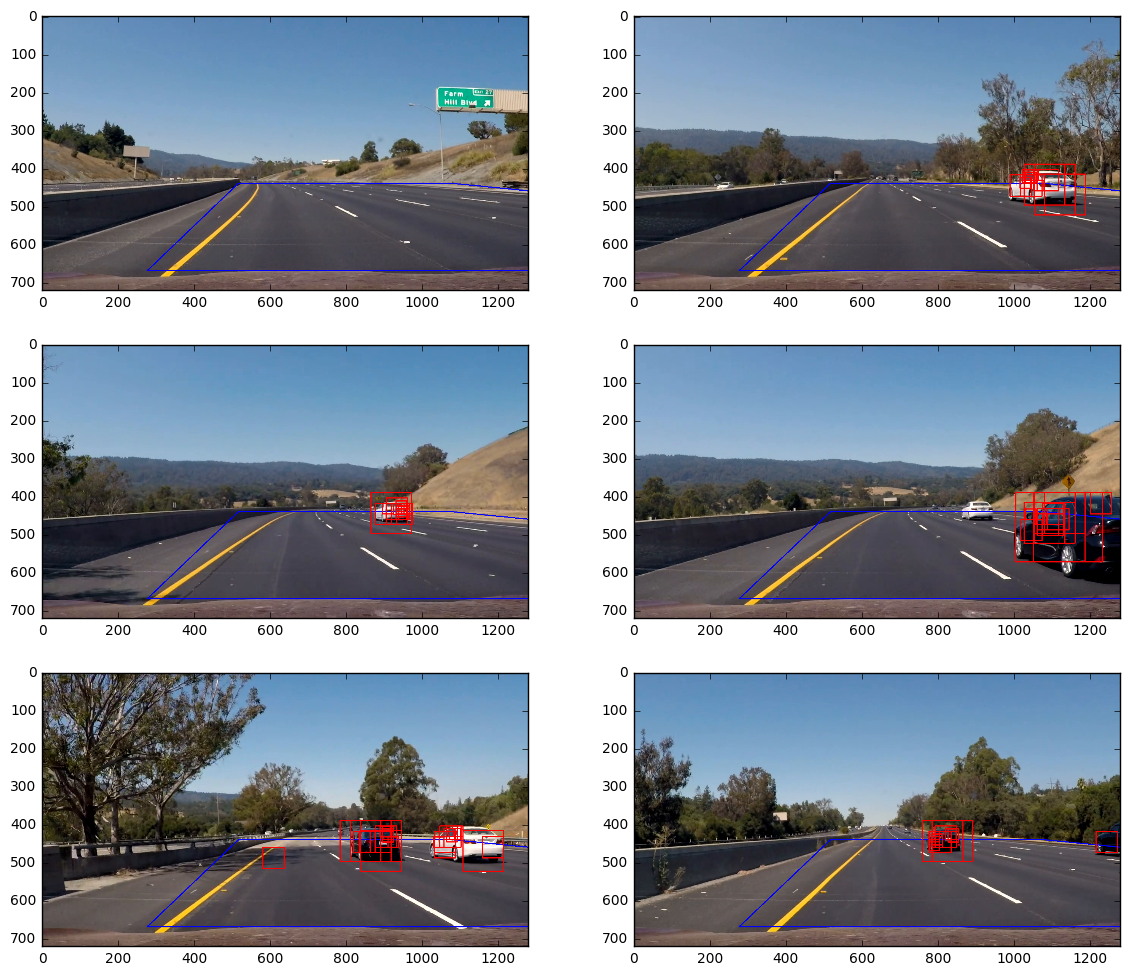

In [24]:
clf=Classifier(svc, minDist=0.5)
scanner=Scan(clf, X_scaler)

plt.figure(figsize=(14,12))

boxes_frames=[]

from lib import draw_boxes

for i in range(6):
    draw_image=np.uint8(np.copy(images[i])*255)
    cv2.polylines(draw_image, np.array([scanner.to_global(groundWindow)]), 1, (0,0,255), 2)

    boxes=scanner.scan_global(images[i])
#    boxes=scanner.scan_local(images[i], [])

    draw_image=draw_boxes(draw_image, boxes, color=(255, 0, 0), thick=2)
    boxes_frames.append(boxes)
    
    plt.subplot(3, 2, i+1)
    plt.imshow(draw_image)
    

### Multiple Detections and False Positives

Let's have a look at (thersholded, labelled) heat maps:

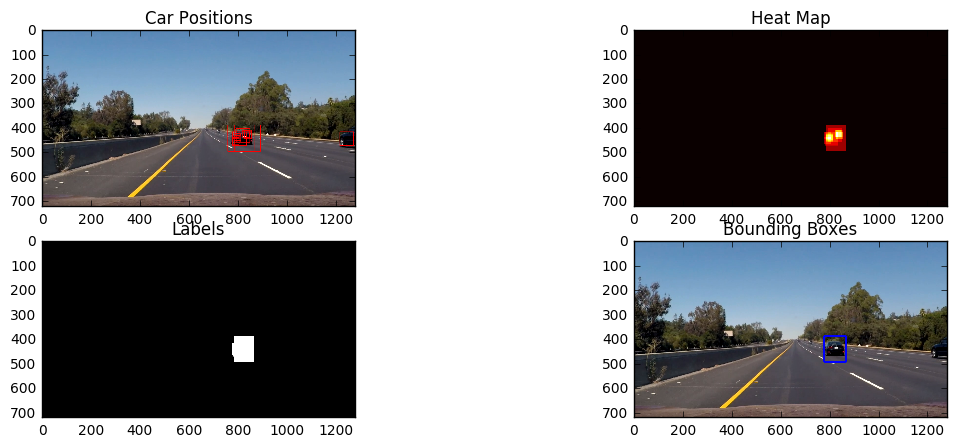

In [25]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

i=5
boxes=boxes_frames[i]
image=images[i]

plt.figure(figsize=(14,5))

#roi=(region_of_interest(image, globalWindow)*255).astype(np.uint8)
draw_img=(image*255).astype(np.uint8)
draw_img = draw_boxes(draw_img, boxes, color=(255, 0, 0), thick=2)
plt.subplot(221)
plt.imshow(draw_img)
plt.title('Car Positions')

heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes((image*255).astype(np.uint8), labels)

plt.subplot(222)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(223)
plt.imshow(labels[0], cmap='gray')
plt.title('Labels')
plt.subplot(224)
plt.imshow(draw_img)
plt.title('Bounding Boxes')
#fig.tight_layout()


## Video Implementation
---

### Pipeline

- Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)


- Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

The pipeline for video processing is defined in the method `pipelineTracking()`, class `ProcessImage`.

In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from helpers import *
from lib2 import get_labeled_bboxes, draw_labeled_bboxes2

class ProcessImage():
    def __init__(self, scanner, text_file):
        self.text_file=text_file
        self.scanner=scanner
        self.heat = None
        self.bboxes = None
        self.counter = 0

    def pipelineTracking(self, image):
        img = image.astype(np.float32)/255
        draw_image=np.copy(image)
        
        #if self.counter>=25:
        #    self.counter=0
        if self.counter==0:
            boxes=self.scanner.scan_global(img)
        else:
            boxes=self.scanner.scan_local(img, self.bboxes)

        p=0.85
        if self.heat!=None:
            self.heat=self.heat*p
        else:
            self.heat = np.zeros_like(image[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        self.heat = add_heat(self.heat,boxes)

        # Apply threshold to help remove false positives
        heat = apply_threshold(self.heat,1*0.5/(1-p))

        # Visualize the heatmap when displaying    
        heatmap = np.clip(self.heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
        self.bboxes = get_labeled_bboxes(labels)
        result = draw_labeled_bboxes2(np.copy(image), self.bboxes)

        # inset image
        h=self.heat*10
        statimg=np.zeros_like(draw_img); 
        statimg[:,:,0]=np.clip(h, 0, 255).astype(np.uint8)
        statimg[:,:,1]=(np.clip(h, 256, 511)-256).astype(np.uint8)
        statimg[:,:,2]=(np.clip(h, 512, 512+255)-512).astype(np.uint8)
        statimg=cv2.resize(statimg, None, fx=1/4, fy=1/4)
        y_offset=50; x_offset=result.shape[1]-statimg.shape[1]-80
        result[y_offset:y_offset+statimg.shape[0], x_offset:x_offset+statimg.shape[1]] = statimg
        
        self.counter=1
        
        return result

    def __call__(self, image):
        
        result=self.pipelineTracking(image)
        
        return result

video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4") # .subclip(0, 1)
#video_output = 'test_video_out.mp4'
#clip1 = VideoFileClip("test_video.mp4")

clf=Classifier(svc, minDist=0.75)
scanner=Scan(clf, X_scaler)

text_file = open("Output.txt", "w")
process_image=ProcessImage(scanner, text_file)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)
text_file.close()


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [12:44<00:00,  1.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 25min 10s, sys: 3.66 s, total: 25min 14s
Wall time: 12min 44s


### Discussion
---

- Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

We have only few cars on the road, with speeds that compare to our own speed. So relative speeds are relatively low. If that changes, one has to think carefully about filtering. Fast overtaking cars could happen to move too fast for the slow filter that has been used here to smoothen the bounding boxes and to suppress false positives. One possible solution could be the following: At positions where there are already bounding boxes there is high confidence to find a car (which is reason for looking at this position in method `scan_local()`, class `Scan`). Given this high confidence, one could give higher weight to detections in these regions, while lowering weight to detections at global search. In addition, it is possible to use different distances to the decision surface for global scanning and for scanning the region around a bounding box that has already been found.

A major issue seems to be the computation effort. On my very modern 3.4GHz core i7 machine, I get about 1.5 to 2.5 frames per second during video processing. This is far from real time processing... I guess, utilizing the graphics card, or implementing the pipeline in C++ (or both) could eventually help.

Of course, the pipeline has been optimized on the available project video with perfect weather conditions. It is very likely that bad weather, or dark night, will make the pipeline fail.

Last but not least: I guess it is possible to improve detection accuracy using a CNN.


In [38]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))